# Recommendation Systems 

### Imports

In [ ]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e5105630d8a7bb52eb79d272d2490671a64648ee968b6544c26c9066d4a1ae4d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## Support functions and variables

In [ ]:
wget.download("https://github.com/MIE451-2022/course-datasets/blob/main/ml-100k.zip?raw=true")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [ ]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [ ]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating    
    
    ###########         end         ###########
    return matrix

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
         # Initialize the predicted rating matrix with zeros
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                #print(user)
                userVector = train_matrix[user, :]
                #print(userVector)
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
    
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
popularity_recsys = BaseLineRecSys('popularity')

In [ ]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
x = popularity_recsys.getModel()

In [ ]:
np.all(x<=1)

True

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:12, 1605.03it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [ ]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [ ]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [ ]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [ ]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3748.76it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


In [ ]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1 /(1 + pairwise_distances(matrix, metric='euclidean'))
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1/ (1 +pairwise_distances(matrix, metric='manhattan'))
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        #print(train_matrix)
        if self.base == 'user':
            ########### your code goes here ###########
          # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            #if k is not None:
            #    uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(temp_matrix)
            #print(normalizer[0])
            #print(len(normalizer[0]))
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
             # Initialize the predicted rating matrix with zeros
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            #if k is not None:
            #    uu_similarity = kNearestNeighbor(uu_similarity, k)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [ ]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [ ]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

 I used manhattan b/c the dimensionality of the data is high

In [ ]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [ ]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [ ]:
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [ ]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3739.57it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [ ]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only'
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1*np.random.randn(num_item,self.num_feat)  # item M x D 
        self.w_User = 0.1*np.random.randn(num_user,self.num_feat)
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
                #print(len(batch_UserID))
                #print(len(batch_ItemID))
                #print(len(self.w_User[batch_UserID,:]))
                #print(len(self.w_Item[batch_ItemID,:]))
                #a = np.multiply(self.w_User[batch_UserID,:],self.w_Item[batch_ItemID,:])
                #print(a)
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID,:],self.w_Item[batch_ItemID,:]),axis = 1)#size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx,:],self.w_Item[train_item_idx,:]),axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx,:],self.w_Item[val_item_idx,:]),axis=1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [ ]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

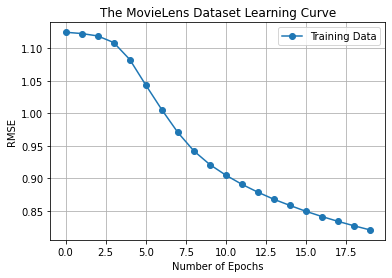

In [ ]:
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

In [ ]:
# since overfit occur at epoch = 20, stop at 20

 popularity cannot be evaluated from RSME, because popularity = number of likes/number of rated, so measure RSME will get large error

 user cosine did best in precision at k
PMF did best in RMSE
user cosine did best in RPrecision

good performance in RSME means good performance in ranking metric, but not vice versa, because RSME weight each item or user equally, so it does not consider ranking

In [ ]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Matrix_Q6 = dataPreprocessor(rating_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_cosine_recsys = SimBasedRecSys.cosine(Matrix_Q6.T)
def itemTop5(item_cosine_recsys,moviesDataset, movieID):
    top5_item_index = np.argsort(item_cosine_recsys[movieID-1])[-6:]
    item_name = moviesDF.movieTitle[movieID-1]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], top5_item_index))
    return item_name,namesTopK

In [ ]:
itemTop5(item_cosine_recsys,moviesDF,2)

('GoldenEye (1995)',
 ['Stargate (1994)',
  'Batman (1989)',
  'True Lies (1994)',
  'Top Gun (1986)',
  'Under Siege (1992)',
  'GoldenEye (1995)'])

In [ ]:
#userVector = user_cosine_recsys.getModel()[5,:]
#print(userVector)
#topK = nlargest(5, range(len(userVector)), userVector.take)
#print(topK)

[3.87368929 3.1186176  2.91475402 ... 3.64141414 3.64141414 3.64141414]
[1200, 1535, 1121, 1188, 1292]


In [ ]:
#similarity_matrix = item_cosine_recsys.getModel()
#print(similarity_matrix)
#print(np.argsort(similarity_matrix[5])[::-1][1:6])
#print(np.argsort(similarity_matrix[5])[-5:])

[[3.75311999 3.66677645 3.68489042 ... 0.         0.         0.        ]
 [3.78949089 3.7482462  3.73847608 ... 0.         0.         0.        ]
 [2.77779386 2.84994197 2.77474888 ... 0.         0.         0.        ]
 ...
 [4.47534873 4.47517784 4.43203328 ... 0.         0.         0.        ]
 [4.32584989 4.36680337 4.34813013 ... 0.         0.         0.        ]
 [3.74031422 3.72661457 3.71972321 ... 0.         0.         0.        ]]
[1308 1305 1592 1621 1331]
[1621 1592 1305 1308 1309]


In [ ]:
# yes GoldenEye  is in horror movie gener, and rest of the are all horror movie
moviesDF[moviesDF['movieTitle'].isin(['GoldenEye (1995)','Stargate (1994)','Batman (1989)','True Lies (1994)','Top Gun (1986)','Under Siege (1992)'])].iloc[:,5:]
#titanic[titanic["Pclass"].isin([2, 3])]

#moviesDF[moviesDF['movieTitle'] == 'Stargate (1994)'].iloc[:,5:])
#moviesDF[moviesDF['movieTitle'] == 'Batman (1989)'].iloc[:,5:]
#moviesDF[moviesDF['movieTitle'] == 'True Lies (1994)'].iloc[:,5:]
#moviesDF[moviesDF['movieTitle'] == 'Under Siege (1992)'].iloc[:,5:]


,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
61,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
160,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
232,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
402,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


top 5 movie are all action movie and most of them are adventure

In [ ]:
item_cosine_recsys_PMF = SimBasedRecSys.cosine(pmf.w_Item.T)

def itemTop5(item_cosine_recsys,moviesDataset, movieID):
    top5_item_index = np.argsort(item_cosine_recsys[movieID-1])[-6:]
    item_name = moviesDF.movieTitle[movieID-1]
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], top5_item_index))
    return item_name,namesTopK

In [ ]:
itemTop5(item_cosine_recsys_PMF,moviesDF,2)

('GoldenEye (1995)',
 ['Toy Story (1995)',
  'Twelve Monkeys (1995)',
  'Dead Man Walking (1995)',
  'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
  'Richard III (1995)',
  'GoldenEye (1995)'])

In [ ]:
top5_list = ['Toy Story (1995)',
  'Twelve Monkeys (1995)',
  'Dead Man Walking (1995)',
  'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
  'Richard III (1995)',
  'GoldenEye (1995)']
moviesDF[moviesDF['movieTitle'].isin(top5_list)].iloc[:,5:]


,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0



works well too because 4 of them has drama genere which is very hard to identify 